Loading models...

===== Processing: test1.jpg =====
Plate 1 box=(40,136,110,161) crop=70x25 conf=0.788


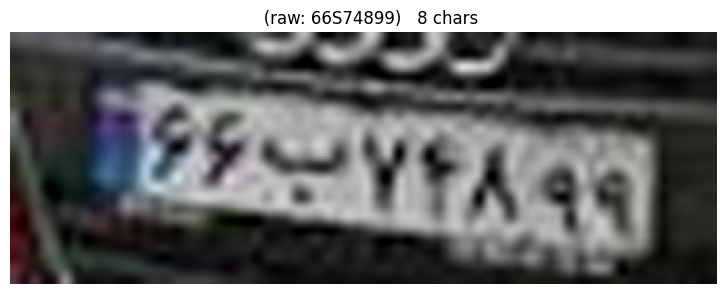

  Raw classes : 66S74899
  Mapped text : 
  Final plate : 
  Char count  : 8
  Plate conf  : 0.788
  → Saved as: test1_plate1_unknown.jpg

===== Processing: test2.jpg =====
Plate 1 box=(113,102,179,117) crop=66x15 conf=0.808


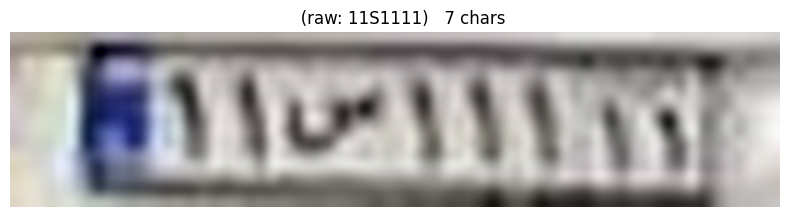

  Raw classes : 11S1111
  Mapped text : 
  Final plate : 
  Char count  : 7
  Plate conf  : 0.808
  → Saved as: test2_plate1_unknown.jpg

===== Processing: test3.jpg =====
Plate 1 box=(42,102,119,124) crop=77x22 conf=0.711


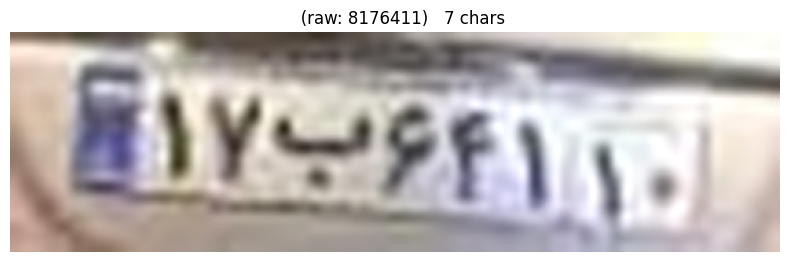

  Raw classes : 8176411
  Mapped text : 
  Final plate : 
  Char count  : 7
  Plate conf  : 0.711
  → Saved as: test3_plate1_unknown.jpg

Processing complete ✓



In [6]:
import cv2
from ultralytics import YOLO
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

# ─── Configuration ──────────────────────────────────────────────────────────────
# PLATE_MODEL = "models/plate-model.pt"
PLATE_MODEL = "models/best.pt"

CHAR_MODEL  = "models/ocr-model.pt"
# CHAR_MODEL  = "models/plate.pt"

CONF_PLATE = 0.55
CONF_CHAR  = 0.35

CROP_DIR = Path("plate_crops")
CROP_DIR.mkdir(parents=True, exist_ok=True)

IMAGES = [
    "photos/test1.jpg",
    "photos/test2.jpg",
    "photos/test3.jpg",
]

CLASS_TO_CHAR = {
    'zero': '0', 'one': '1', 'two': '2', 'three': '3', 'four': '4',
    'five': '5', 'six': '6', 'seven': '7', 'eight': '8', 'nine': '9',
    'Alef': 'الف', 'Ayn': 'ع', 'B': 'ب', 'D': 'د', 'Gh': 'ق',
    'J': 'ج', 'L': 'ل', 'M': 'م', 'N': 'ن', 'Sad': 'ص',
    'Sin': 'س', 'Ta': 'ط', 'Te': 'ت', 'V': 'و', 'i': 'ی',
}

VALID_CHARS = set('0123456789ابپتجچحخدذرزژسشصضطظعغفقکگلمنوهی')

# ─── Helpers ───────────────────────────────────────────────────────────────────
def preprocess_plate_crop(crop_bgr):
    """
    Mild preprocess: grayscale + CLAHE, then back to BGR (YOLO expects 3-channel).
    """
    if crop_bgr is None or crop_bgr.size == 0:
        return crop_bgr
    gray = cv2.cvtColor(crop_bgr, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(6, 6))
    enhanced = clahe.apply(gray)
    return cv2.cvtColor(enhanced, cv2.COLOR_GRAY2BGR)

def pad_and_clip_box(x1, y1, x2, y2, img_w, img_h, pad_ratio=0.12):
    """
    Add padding around plate bbox and clip to image boundaries.
    """
    w = x2 - x1
    h = y2 - y1
    pad_x = int(w * pad_ratio)
    pad_y = int(h * pad_ratio)

    x1 = max(0, x1 - pad_x)
    y1 = max(0, y1 - pad_y)
    x2 = min(img_w - 1, x2 + pad_x)
    y2 = min(img_h - 1, y2 + pad_y)
    return x1, y1, x2, y2

def upscale_if_small(crop, target_h=160):
    """
    If crop is small, upscale it to target height while preserving aspect ratio.
    """
    if crop is None or crop.size == 0:
        return crop
    h, w = crop.shape[:2]
    if h >= target_h:
        return crop
    scale = target_h / max(h, 1)
    new_w = max(1, int(w * scale))
    return cv2.resize(crop, (new_w, target_h), interpolation=cv2.INTER_CUBIC)

def map_class_names_to_text(class_list):
    result = []
    for cls in class_list:
        ch = CLASS_TO_CHAR.get(cls)
        if ch is not None:
            result.append(ch)
    return ''.join(result)

def filter_and_sort_chars(char_detections, crop_width, min_center_dist_ratio=0.04):
    """
    char_detections: list of (box_xyxy, cls_name)
    returns filtered list sorted left-to-right.
    """
    if not char_detections:
        return []

    with_center = [(((box[0] + box[2]) / 2), box, name) for box, name in char_detections]
    with_center.sort(key=lambda x: x[0])

    min_dist = crop_width * min_center_dist_ratio
    filtered = []
    last_center = -1e9

    for cx, box, name in with_center:
        if cx - last_center >= min_dist:
            filtered.append((box, name))
            last_center = cx

    return filtered

# ─── Main ──────────────────────────────────────────────────────────────────────
def main():
    print("Loading models...")
    plate_model = YOLO(PLATE_MODEL)
    char_model  = YOLO(CHAR_MODEL)

    for img_str in IMAGES:
        img_path = Path(img_str)
        if not img_path.exists():
            print(f"File not found: {img_path}")
            continue

        print(f"\n===== Processing: {img_path.name} =====")

        img = cv2.imread(str(img_path))
        if img is None:
            print("Failed to read image!")
            continue

        H, W = img.shape[:2]

        # Detect plates
        plate_res = plate_model(img_path, verbose=False)[0]
        plates = [b for b in plate_res.boxes if float(b.conf) >= CONF_PLATE]

        if not plates:
            print("No plate detected with sufficient confidence.")
            continue

        for i, b in enumerate(plates, 1):
            conf = float(b.conf)
            x1, y1, x2, y2 = map(int, b.xyxy[0])

            # Add padding + clip
            x1, y1, x2, y2 = pad_and_clip_box(x1, y1, x2, y2, W, H, pad_ratio=0.12)

            # Crop
            crop = img[y1:y2, x1:x2]
            if crop is None or crop.size == 0:
                print(f"Plate {i} crop invalid → skipped")
                continue

            crop_h, crop_w = crop.shape[:2]
            print(f"Plate {i} box=({x1},{y1},{x2},{y2}) crop={crop_w}x{crop_h} conf={conf:.3f}")

            # If small, upscale (instead of skipping)
            crop = upscale_if_small(crop, target_h=160)
            crop_h, crop_w = crop.shape[:2]

            # Preprocess
            processed_crop = preprocess_plate_crop(crop)

            # Save temp for char model
            temp_path = CROP_DIR / f"{img_path.stem}_plate{i}_temp.jpg"
            cv2.imwrite(str(temp_path), processed_crop)

            # Character detection
            char_res = char_model(temp_path, verbose=False)[0]

            chars = []
            for cb in char_res.boxes:
                if float(cb.conf) < CONF_CHAR:
                    continue
                cls_name = char_res.names[int(cb.cls)]
                box_xyxy = cb.xyxy[0].cpu().numpy().astype(int)
                chars.append((box_xyxy, cls_name))

            if len(chars) < 3:
                print(f"Plate {i} → too few characters ({len(chars)})")
                temp_path.unlink(missing_ok=True)
                continue

            # Sort & filter
            filtered_chars = filter_and_sort_chars(chars, crop_w, min_center_dist_ratio=0.04)
            if len(filtered_chars) < 3:
                print(f"Plate {i} → too few after filtering ({len(filtered_chars)})")
                temp_path.unlink(missing_ok=True)
                continue

            class_names = [name for _, name in filtered_chars]
            raw = ''.join(class_names)
            mapped = map_class_names_to_text(class_names)
            final = ''.join(c for c in mapped if c in VALID_CHARS)[:10]

            # Show ORIGINAL (current) crop
            plt.figure(figsize=(8, 3))
            plt.imshow(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.title(f"{final}   (raw: {raw})   {len(filtered_chars)} chars")
            plt.tight_layout()
            plt.show()

            print(f"  Raw classes : {raw}")
            print(f"  Mapped text : {mapped}")
            print(f"  Final plate : {final}")
            print(f"  Char count  : {len(filtered_chars)}")
            print(f"  Plate conf  : {conf:.3f}")

            # Save crop with final name
            try:
                safe_final = "".join(c if c.isalnum() else "_" for c in final) or "unknown"
                new_name = f"{img_path.stem}_plate{i}_{safe_final}.jpg"
                final_path = CROP_DIR / new_name
                cv2.imwrite(str(final_path), crop)
                print(f"  → Saved as: {new_name}")
            except Exception as e:
                print(f"  → Save failed: {e}")

            temp_path.unlink(missing_ok=True)

    print("\nProcessing complete ✓\n")

if __name__ == "__main__":
    main()


Loading models...

===== Processing: test1.jpg =====


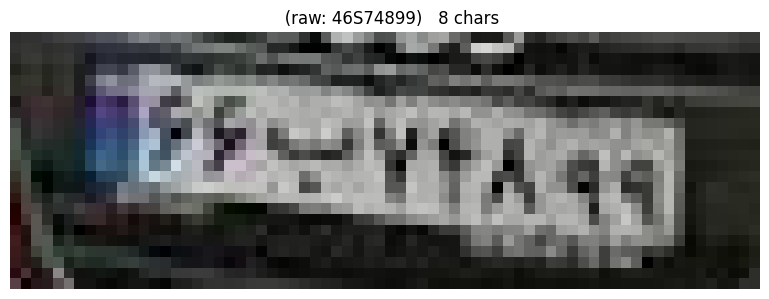

  Final plate : 
  Char count  : 8
  Plate conf  : 0.878
  → Saved as: test1_plate1_unknown.png

===== Processing: test2.jpg =====


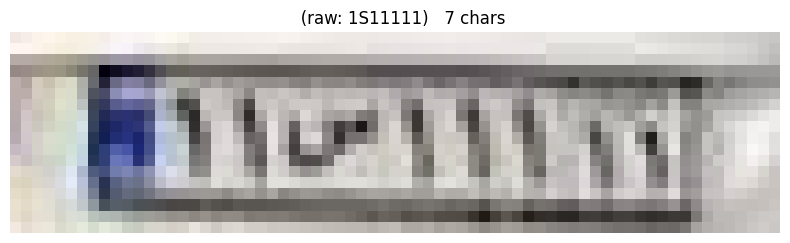

  Final plate : 
  Char count  : 7
  Plate conf  : 0.863
  → Saved as: test2_plate1_unknown.png

===== Processing: test3.jpg =====


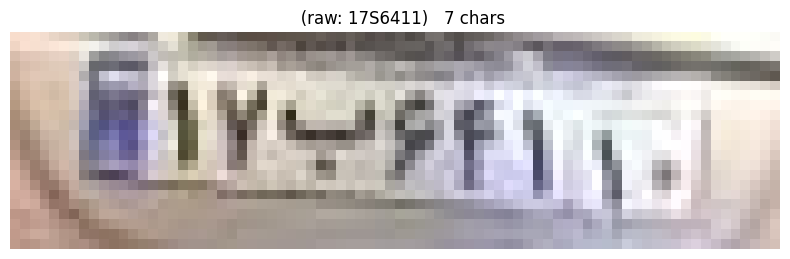

  Final plate : 
  Char count  : 7
  Plate conf  : 0.855
  → Saved as: test3_plate1_unknown.png

Processing complete ✓



In [10]:
import cv2
from ultralytics import YOLO
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

PLATE_MODEL = "models/plate-model.pt"
CHAR_MODEL  = "models/ocr-model.pt"

CONF_PLATE = 0.55
CONF_CHAR  = 0.35

CROP_DIR = Path("plate_crops")
CROP_DIR.mkdir(parents=True, exist_ok=True)

IMAGES = [
    "photos/test1.jpg",
    "photos/test2.jpg",
    "photos/test3.jpg",
]

CLASS_TO_CHAR = {
    'zero': '0', 'one': '1', 'two': '2', 'three': '3', 'four': '4',
    'five': '5', 'six': '6', 'seven': '7', 'eight': '8', 'nine': '9',
    'Alef': 'الف', 'Ayn': 'ع', 'B': 'ب', 'D': 'د', 'Gh': 'ق',
    'J': 'ج', 'L': 'ل', 'M': 'م', 'N': 'ن', 'Sad': 'ص',
    'Sin': 'س', 'Ta': 'ط', 'Te': 'ت', 'V': 'و', 'i': 'ی',
}

VALID_CHARS = set('0123456789ابپتجچحخدذرزژسشصضطظعغفقکگلمنوهی')

def pad_and_clip_box(x1, y1, x2, y2, img_w, img_h, pad_ratio=0.12):
    w = x2 - x1
    h = y2 - y1
    pad_x = int(w * pad_ratio)
    pad_y = int(h * pad_ratio)
    x1 = max(0, x1 - pad_x); y1 = max(0, y1 - pad_y)
    x2 = min(img_w - 1, x2 + pad_x); y2 = min(img_h - 1, y2 + pad_y)
    return x1, y1, x2, y2

def letterbox(image, new_shape=(320, 320), color=(114, 114, 114)):
    """
    Resize with padding (no distortion). Similar to YOLO letterbox.
    """
    h, w = image.shape[:2]
    nh, nw = new_shape

    r = min(nw / w, nh / h)
    new_unpad = (int(round(w * r)), int(round(h * r)))

    resized = cv2.resize(image, new_unpad, interpolation=cv2.INTER_LINEAR)

    dw = nw - new_unpad[0]
    dh = nh - new_unpad[1]
    top = dh // 2
    bottom = dh - top
    left = dw // 2
    right = dw - left

    padded = cv2.copyMakeBorder(resized, top, bottom, left, right,
                                cv2.BORDER_CONSTANT, value=color)
    return padded

def map_class_names_to_text(class_list):
    return ''.join(CLASS_TO_CHAR.get(x, '') for x in class_list)

def filter_and_sort_chars(char_detections, crop_width, min_center_dist_ratio=0.04):
    if not char_detections:
        return []
    with_center = [(((box[0] + box[2]) / 2), box, name) for box, name in char_detections]
    with_center.sort(key=lambda x: x[0])

    min_dist = crop_width * min_center_dist_ratio
    filtered = []
    last_center = -1e9
    for cx, box, name in with_center:
        if cx - last_center >= min_dist:
            filtered.append((box, name))
            last_center = cx
    return filtered

def main():
    print("Loading models...")
    plate_model = YOLO(PLATE_MODEL)
    char_model  = YOLO(CHAR_MODEL)

    for img_str in IMAGES:
        img_path = Path(img_str)
        if not img_path.exists():
            print(f"File not found: {img_path}")
            continue

        print(f"\n===== Processing: {img_path.name} =====")
        img = cv2.imread(str(img_path))
        if img is None:
            print("Failed to read image!")
            continue

        H, W = img.shape[:2]

        # Plate detection
        plate_res = plate_model(img, verbose=False)[0]
        plates = [b for b in plate_res.boxes if float(b.conf) >= CONF_PLATE]
        if not plates:
            print("No plate detected with sufficient confidence.")
            continue

        for i, b in enumerate(plates, 1):
            conf = float(b.conf)
            x1, y1, x2, y2 = map(int, b.xyxy[0])

            # padding so crop isn't too tight
            x1, y1, x2, y2 = pad_and_clip_box(x1, y1, x2, y2, W, H, pad_ratio=0.12)

            crop_original = img[y1:y2, x1:x2]
            if crop_original is None or crop_original.size == 0:
                print(f"Plate {i} crop invalid → skipped")
                continue

            # ---- IMPORTANT: NO preprocess ----
            # Just letterbox for the char model
            crop_for_char = letterbox(crop_original, new_shape=(320, 320))

            # Char detection
            char_res = char_model(crop_for_char, verbose=False)[0]

            chars = []
            for cb in char_res.boxes:
                if float(cb.conf) < CONF_CHAR:
                    continue
                cls_name = char_res.names[int(cb.cls)]
                box_xyxy = cb.xyxy[0].cpu().numpy().astype(int)
                chars.append((box_xyxy, cls_name))

            if len(chars) < 3:
                print(f"Plate {i} → too few characters ({len(chars)})")
                continue

            filtered = filter_and_sort_chars(chars, crop_for_char.shape[1], 0.03)

            class_names = [name for _, name in filtered]
            raw = ''.join(class_names)
            mapped = map_class_names_to_text(class_names)
            final = ''.join(c for c in mapped if c in VALID_CHARS)[:10]

            # Show crop original (best quality)
            plt.figure(figsize=(8, 3))
            plt.imshow(cv2.cvtColor(crop_original, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.title(f"{final}   (raw: {raw})   {len(filtered)} chars")
            plt.tight_layout()
            plt.show()

            print(f"  Final plate : {final}")
            print(f"  Char count  : {len(filtered)}")
            print(f"  Plate conf  : {conf:.3f}")

            # Save original crop as PNG (no quality loss)
            safe_final = "".join(c if c.isalnum() else "_" for c in final) or "unknown"
            out_path = CROP_DIR / f"{img_path.stem}_plate{i}_{safe_final}.png"
            cv2.imwrite(str(out_path), crop_original)
            print(f"  → Saved as: {out_path.name}")

            # Optional debug: save what char model actually saw
            dbg_path = CROP_DIR / f"debug_{img_path.stem}_plate{i}_charInput.png"
            cv2.imwrite(str(dbg_path), crop_for_char)

    print("\nProcessing complete ✓\n")

if __name__ == "__main__":
    main()


Loading models...

===== Processing: test1.jpg =====


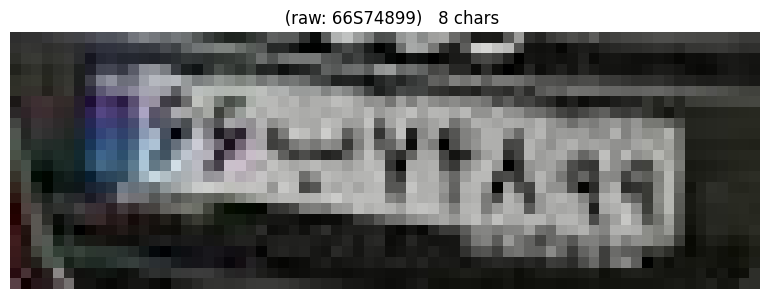

  Final plate : 
  Plate conf  : 0.878
  → Saved as: test1_plate1_unknown.png

===== Processing: test2.jpg =====


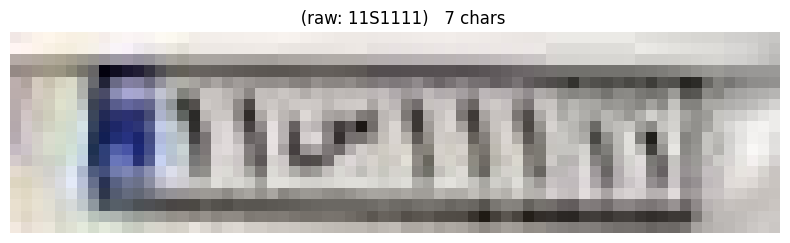

  Final plate : 
  Plate conf  : 0.863
  → Saved as: test2_plate1_unknown.png

===== Processing: test3.jpg =====


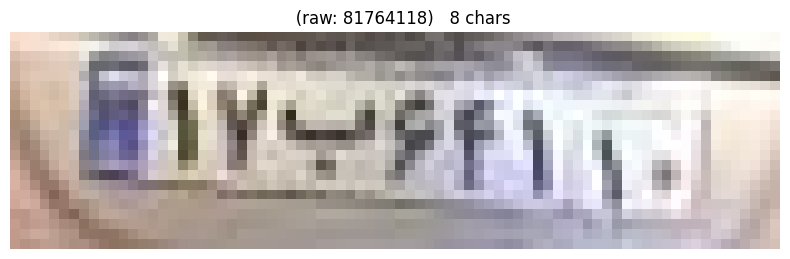

  Final plate : 
  Plate conf  : 0.855
  → Saved as: test3_plate1_unknown.png

Processing complete ✓



In [15]:
import cv2
from ultralytics import YOLO
from pathlib import Path
import matplotlib.pyplot as plt

PLATE_MODEL = "models/plate-model.pt"
CHAR_MODEL  = "models/ocr-model.pt"

CONF_PLATE = 0.55
CONF_CHAR  = 0.35

CROP_DIR = Path("plate_crops")
CROP_DIR.mkdir(parents=True, exist_ok=True)

IMAGES = [
    "photos/test1.jpg",
    "photos/test2.jpg",
    "photos/test3.jpg",
]

CLASS_TO_CHAR = {
    'zero': '0', 'one': '1', 'two': '2', 'three': '3', 'four': '4',
    'five': '5', 'six': '6', 'seven': '7', 'eight': '8', 'nine': '9',
    'Alef': 'الف', 'Ayn': 'ع', 'B': 'ب', 'D': 'د', 'Gh': 'ق',
    'J': 'ج', 'L': 'ل', 'M': 'م', 'N': 'ن', 'Sad': 'ص',
    'Sin': 'س', 'Ta': 'ط', 'Te': 'ت', 'V': 'و', 'i': 'ی',
}

VALID_CHARS = set('0123456789ابپتجچحخدذرزژسشصضطظعغفقکگلمنوهی')

def preprocess_plate_crop(crop_bgr):
    if crop_bgr is None or crop_bgr.size == 0:
        return crop_bgr
    gray = cv2.cvtColor(crop_bgr, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(6, 6))
    enhanced = clahe.apply(gray)
    return cv2.cvtColor(enhanced, cv2.COLOR_GRAY2BGR)

def pad_and_clip_box(x1, y1, x2, y2, img_w, img_h, pad_ratio=0.12):
    w = x2 - x1
    h = y2 - y1
    pad_x = int(w * pad_ratio)
    pad_y = int(h * pad_ratio)

    x1 = max(0, x1 - pad_x)
    y1 = max(0, y1 - pad_y)
    x2 = min(img_w - 1, x2 + pad_x)
    y2 = min(img_h - 1, y2 + pad_y)
    return x1, y1, x2, y2

def upscale_if_small(crop, target_h=160):
    if crop is None or crop.size == 0:
        return crop
    h, w = crop.shape[:2]
    if h >= target_h:
        return crop
    scale = target_h / max(h, 1)
    new_w = max(1, int(w * scale))
    return cv2.resize(crop, (new_w, target_h), interpolation=cv2.INTER_CUBIC)

def map_class_names_to_text(class_list):
    return ''.join(CLASS_TO_CHAR.get(cls, '') for cls in class_list)

def filter_and_sort_chars(char_detections, crop_width, min_center_dist_ratio=0.04):
    if not char_detections:
        return []
    with_center = [(((box[0] + box[2]) / 2), box, name) for box, name in char_detections]
    with_center.sort(key=lambda x: x[0])

    min_dist = crop_width * min_center_dist_ratio
    filtered = []
    last_center = -1e9
    for cx, box, name in with_center:
        if cx - last_center >= min_dist:
            filtered.append((box, name))
            last_center = cx
    return filtered

def main():
    print("Loading models...")
    plate_model = YOLO(PLATE_MODEL)
    char_model  = YOLO(CHAR_MODEL)

    for img_str in IMAGES:
        img_path = Path(img_str)
        if not img_path.exists():
            print(f"File not found: {img_path}")
            continue

        print(f"\n===== Processing: {img_path.name} =====")
        img = cv2.imread(str(img_path))
        if img is None:
            print("Failed to read image!")
            continue

        H, W = img.shape[:2]

        plate_res = plate_model(img_path, verbose=False)[0]
        plates = [b for b in plate_res.boxes if float(b.conf) >= CONF_PLATE]
        if not plates:
            print("No plate detected with sufficient confidence.")
            continue

        for i, b in enumerate(plates, 1):
            conf = float(b.conf)
            x1, y1, x2, y2 = map(int, b.xyxy[0])
            x1, y1, x2, y2 = pad_and_clip_box(x1, y1, x2, y2, W, H, pad_ratio=0.12)

            crop_original = img[y1:y2, x1:x2]
            if crop_original is None or crop_original.size == 0:
                print(f"Plate {i} crop invalid → skipped")
                continue

            # ✅ فقط برای OCR: upscale + preprocess
            crop_for_ocr = upscale_if_small(crop_original, target_h=160)
            crop_for_ocr = preprocess_plate_crop(crop_for_ocr)

            # ✅ temp را PNG ذخیره کن (نه JPG) تا کیفیت خراب نشه
            temp_path = CROP_DIR / f"{img_path.stem}_plate{i}_temp.png"
            cv2.imwrite(str(temp_path), crop_for_ocr)

            char_res = char_model(str(temp_path), verbose=False)[0]

            chars = []
            for cb in char_res.boxes:
                if float(cb.conf) < CONF_CHAR:
                    continue
                cls_name = char_res.names[int(cb.cls)]
                box_xyxy = cb.xyxy[0].cpu().numpy().astype(int)
                chars.append((box_xyxy, cls_name))

            temp_path.unlink(missing_ok=True)

            if len(chars) < 3:
                print(f"Plate {i} → too few characters ({len(chars)})")
                continue

            filtered_chars = filter_and_sort_chars(chars, crop_for_ocr.shape[1], min_center_dist_ratio=0.04)
            if len(filtered_chars) < 3:
                print(f"Plate {i} → too few after filtering ({len(filtered_chars)})")
                continue

            class_names = [name for _, name in filtered_chars]
            raw = ''.join(class_names)
            mapped = map_class_names_to_text(class_names)
            final = ''.join(c for c in mapped if c in VALID_CHARS)[:10]

            # ✅ نمایش: crop اصلی (کیفیت واقعی)
            plt.figure(figsize=(8, 3))
            plt.imshow(cv2.cvtColor(crop_original, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.title(f"{final}   (raw: {raw})   {len(filtered_chars)} chars")
            plt.tight_layout()
            plt.show()

            print(f"  Final plate : {final}")
            print(f"  Plate conf  : {conf:.3f}")

            # ✅ ذخیره: crop اصلی با کیفیت (PNG بهتره)
            safe_final = "".join(c if c.isalnum() else "_" for c in final) or "unknown"
            out_path = CROP_DIR / f"{img_path.stem}_plate{i}_{safe_final}.png"
            cv2.imwrite(str(out_path), crop_original)
            print(f"  → Saved as: {out_path.name}")

    print("\nProcessing complete ✓\n")

if __name__ == "__main__":
    main()
